## Dependencies

In [1]:
import joblib
import numpy as np
import pandas as pd 
from simpletransformers.classification import ClassificationModel
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

## Paths

In [2]:
paths = {"dataset": '../dataset/bbc_hindi_cleaned',
         "model_path": '../model/hindi_bert_model'}

## Loading the cleaned data

#### Loading the train data

In [3]:
df_train = pd.read_csv(f'{paths["dataset"]}/hindi-cleaned-train.csv')
df_train.columns=['topic','text']

In [4]:
print(df_train.head())

           topic                                               text
0  international  इसराइल की फ़ौज का कहना है कि बंदूक़ों और टैंक ...
1  international  शरणार्थियों के मामले देखने वाले संयुक्त राष्ट्...
2        science  यूरोप में वैज्ञानिकों का कहना है कि एक कैन रोज...
3  international  26 वर्षीय निकोलस विग ने कथित तौर पर एक व्यक्ति...
4          sport  श्रीलंका की टीम इस मैच से पहले ही फ़ाइनल में प...


In [5]:
print(set(df_train["topic"].values))
print(len(set(df_train["topic"].values)))

{'entertainment', 'india', 'sport', 'science', 'international'}
5


#### Encoding the classes

In [6]:
labeler = preprocessing.LabelEncoder()

df2 = pd.DataFrame(df_train["text"])
df2 = df2.applymap(str)
df2['label'] = labeler.fit_transform(df_train["topic"])
print(df2.head())

                                                text  label
0  इसराइल की फ़ौज का कहना है कि बंदूक़ों और टैंक ...      2
1  शरणार्थियों के मामले देखने वाले संयुक्त राष्ट्...      2
2  यूरोप में वैज्ञानिकों का कहना है कि एक कैन रोज...      3
3  26 वर्षीय निकोलस विग ने कथित तौर पर एक व्यक्ति...      2
4  श्रीलंका की टीम इस मैच से पहले ही फ़ाइनल में प...      4


#### Loading and encoding the test data

In [7]:
orig_test = pd.read_csv(f'{paths["dataset"]}/hindi-cleaned-test.csv')
orig_test.columns=['topic','text']
eval_frame = pd.DataFrame(orig_test["text"])
eval_frame = eval_frame.applymap(str)
eval_frame['label'] = labeler.fit_transform(orig_test["topic"])
print(eval_frame.head())

                                                text  label
0  लेकिन मीडिया रिपोर्टों के मुताबिक इन उम्मीदवार...      2
1  इसके विषाणुओं से सैकड़ों लोग मारे गए थे और हज़...      3
2  विदेश में हारने के बहाने थे. लेकिन अब अपनी मुं...      4
3  हालांकि थिएटरों के नाटकों में भी कई वर्षों से ...      2
4  शोधकर्ताओं ने 1,250 पाउंड (लगभग एक लाख रुपए) क...      3


In [8]:
print(len(eval_frame))

345


#### Saving the labeler

In [9]:
labeler.classes_

array(['entertainment', 'india', 'international', 'science', 'sport'],
      dtype=object)

In [8]:
joblib.dump(labeler, f'{paths["model_path"]}/labeler_joblib')

['model/myhindi_bert_joblib/labeler_joblib']

## Defining the model

In [ ]:
model = ClassificationModel('electra', 'monsoon-nlp/hindi-bert', num_labels=5, use_cuda=True, args={
    'reprocess_input_data': True,
    'use_cached_eval_features': False,
    'output_dir': f'{paths["model_path"]}/',
    'overwrite_output_dir': True,
    'num_train_epochs': 3,
    'fp16': False,
})

## Training the model

In [ ]:
model.train_model(df2)

Downloading:   0%|          | 0.00/58.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at monsoon-nlp/hindi-bert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/hindi-bert and are newly initialized: ['pooler.dense.weight', 'pooler.dens

Downloading:   0%|          | 0.00/607k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

C:\Users\Danny\AppData\Roaming\Python\Python37\site-packages\simpletransformers\classification\classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1237 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/155 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/155 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/155 [00:00<?, ?it/s]

## Evaluating the model

#### Loading the model

In [10]:
model = joblib.load(f'{paths["model_path"]}/model_joblib')

In [11]:
eval_text = []
eval_label = []

In [12]:
for i in range(len(eval_frame)):
    eval_text.append(eval_frame['text'][i])
    eval_label.append(eval_frame['label'][i])

In [13]:
pred = model.predict(eval_text)

In [14]:
eval_preds = []
for i in range(len(pred[1])):
    eval_preds.append(np.argmax(pred[1][i]))

In [15]:
wrongpreds = 0
for i in range(len(eval_label)):
    if eval_preds[i] != eval_label[i]:
        wrongpreds += 1

#### Accuracy

In [16]:
(len(eval_frame) - wrongpreds)/len(eval_frame)

0.6347826086956522

#### Metrics

In [17]:
y_actual = labeler.inverse_transform(eval_label)

In [18]:
y_predicted = labeler.inverse_transform(eval_preds)

In [19]:
print(classification_report(y_actual, y_predicted))

               precision    recall  f1-score   support

entertainment       0.65      0.87      0.75        71
        india       0.53      0.24      0.33        70
international       0.45      0.59      0.51        70
      science       0.72      0.62      0.67        61
        sport       0.82      0.84      0.83        73

     accuracy                           0.63       345
    macro avg       0.64      0.63      0.62       345
 weighted avg       0.63      0.63      0.62       345



#### Confusion matrix 

<AxesSubplot:xlabel='Predicted Label', ylabel='True Label'>

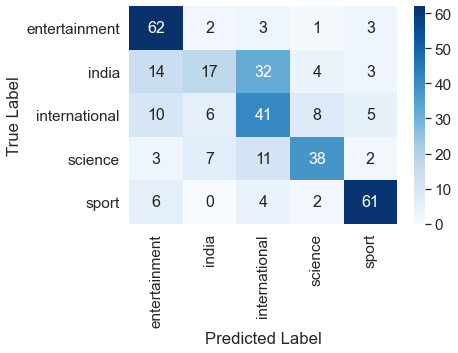

In [25]:
%matplotlib inline
labels = labeler.classes_
conf_matrix = confusion_matrix(y_actual, y_predicted, labels=labels, sample_weight=None, normalize=None)
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted Label'
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt='d')